In [1]:
from pathlib import Path

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

from rdkit.Chem import PandasTools
PandasTools.RenderImagesInAllDataFrames(images=True)

from utils import get_fragmented_ligand, read_fragment_library

In [2]:
# Path to data
PATH_DATA = Path('.') / '..' / 'data'
fragment_library = read_fragment_library(PATH_DATA / 'fragment_library')
fragment_library_reduced = read_fragment_library(PATH_DATA / 'fragment_library_reduced')
fragment_library_reduced.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2'])

In [3]:
def draw_fragmented_ligand_wdummy(fragment_library, complex_pdb, ligand_pdb, mols_per_row=6):
    """
    Show fragments with subpocket assignment for ligand by PDB ID.
    
    Parameters
    ----------
    fragment_library : dict of pandas.DataFrame
        Fragment details, i.e. SMILES, and fragment RDKit molecules, KLIFS and fragmentation details (values)
        for each subpocket (key).
    complex_pdb : str
        PDB ID for structure with ligand of interest.
    ligand_pdb : str
        PDB ID for ligand of interest.
    
    Returns
    -------
    PIL.PngImagePlugin.PngImageFile
        Fragmented ligand.
    """
    
    fragmented_ligand = get_fragmented_ligand(fragment_library, complex_pdb, ligand_pdb)
    
    img = Draw.MolsToGridImage(
        fragmented_ligand.ROMol_dummy.tolist(), 
        legends=fragmented_ligand.subpocket.tolist(), 
        molsPerRow=mols_per_row
    )
    
    return img

### Pick one example from 'Number of exact matches not in theoretical exact matches'
* https://github.com/volkamerlab/KinFragLib/blob/ligand_analysis/notebooks/4_3_combinatorial_library_comparison_klifs.ipynb
* First entry represents **4fsy/HK7**: First row first, first from the left

### Question: Why is 4fsy/HK7 not part of the theoretical exact matches?

#### Theory steps

Get theoretical exact matches: Full vs. reduced fragment library.

* Check for each fragment in full library if it is part of reduced library (based on SMILES, atoms' subpocket and BRICS assignments).
* Group by ligand.
* Filter for ligands where all fragments are in reduced fragment library (all ligands with fragment in pool X will not be theoretical exact matches).
* Filter for ligands that contain AP and have not more than 4 subpockets
* For these ligands, get InChI: mol2 (klifs_utils: fetch ligand mol2 remotely by complex and ligand PDB ID) > ROMol > standardize > InChI

## 1. Check if each part of the molecule is in the reduced fragment library

### Manually check if AP fragment is in reduced library
* Found one: 93 | 1 | 6 | 1 | 4fsy | HK7

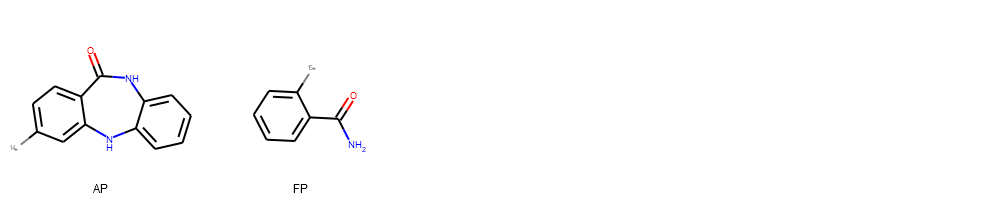

In [4]:
complex_pdb='4fsy'
ligand_pdb='HK7'

draw_fragmented_ligand_wdummy(fragment_library, complex_pdb, ligand_pdb, mols_per_row=5)

### Manually check if FP fragment is in reduced library
* Found 5 times: 4 | 27 | 5 | 5 | 4ded | NHU

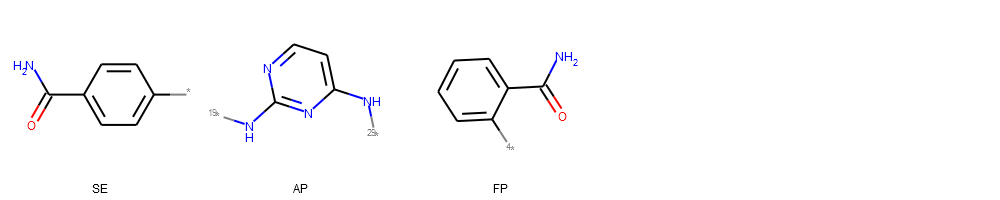

In [5]:
complex_pdb='4ded'
ligand_pdb='NHU'

draw_fragmented_ligand_wdummy(fragment_library, complex_pdb, ligand_pdb, mols_per_row=5)

### -> yes fragments are present
### But in 3_2 result says that ligand is not fully covered, why?
original_ligands_coverage[original_ligands_coverage.complex_pdb=='4fsy'] 

returns (ignore formatting here):
* id	kinase	complex_pdb	ligand_pdb	**is_fully_covered**	is_covered
* 723	CHK1	4fsy	HK7	**False**	True


### Double check selected AP fragment

Shape of AP fragment DataFrame:  (145, 15)
Shape of AP fragment subset:  (1, 15)


,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles,smiles_dummy,subpocket
112,,,,CHK1,CAMKL,CAMK,4fsy,HK7,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 1...,O=C1Nc2ccccc2Nc2ccccc21,*c1ccc2c(c1)Nc1ccccc1NC2=O,AP

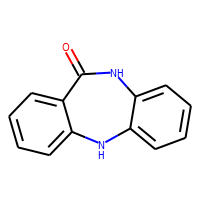
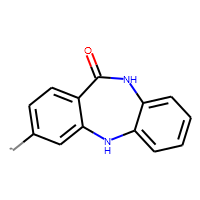
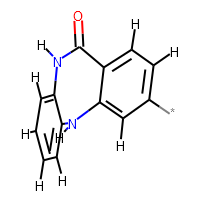

In [6]:
ap_fragments_reduced = fragment_library_reduced['AP']
print('Shape of AP fragment DataFrame: ', ap_fragments_reduced.shape)
ap_fragment_reduced_subset=ap_fragments_reduced[ap_fragments_reduced.smiles=='O=C1Nc2ccccc2Nc2ccccc21']
print('Shape of AP fragment subset: ', ap_fragment_reduced_subset.shape)
ap_fragment_reduced_subset.head()

In [7]:
print(list(ap_fragment_reduced_subset.atom_subpockets))

['AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP FP']


Shape of AP fragment DataFrame:  (2561, 15)
Shape of AP fragment subset:  (6, 15)


,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles,smiles_dummy,subpocket
723,,,,CHK1,CAMKL,CAMK,4fsy,HK7,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 1...,O=C1Nc2ccccc2Nc2ccccc21,[14*]c1ccc2c(c1)Nc1ccccc1NC2=O,AP
725,,,,CHK1,CAMKL,CAMK,4ft0,HK9,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 1...,O=C1Nc2ccccc2Nc2ccccc21,[25*]c1ccc2c(c1)Nc1ccccc1NC2=O,AP
740,,,,CHK1,CAMKL,CAMK,4ftr,5HK,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 1...,O=C1Nc2ccccc2Nc2ccccc21,[11*]c1ccc2c(c1)NC(=O)c1ccc([38*])cc1N2,AP
741,,,,CHK1,CAMKL,CAMK,4ftt,6HK,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 1...,O=C1Nc2ccccc2Nc2ccccc21,[13*]c1ccc2c(c1)NC(=O)c1ccc([34*])cc1N2,AP
742,,,,CHK1,CAMKL,CAMK,4ftu,7HK,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 1...,O=C1Nc2ccccc2Nc2ccccc21,[13*]c1ccc2c(c1)NC(=O)c1ccc([34*])cc1N2,AP

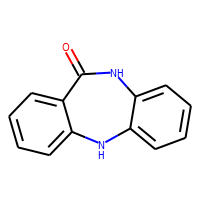
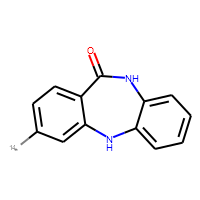
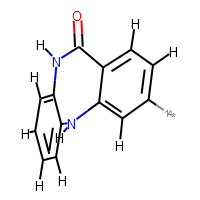
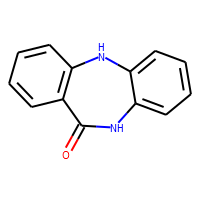
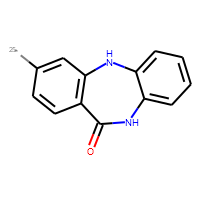
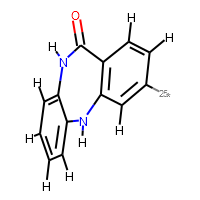
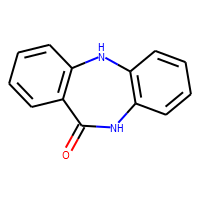
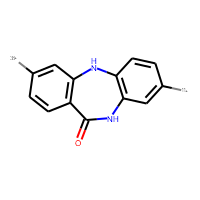
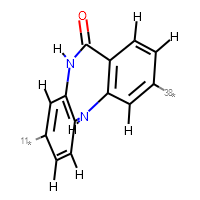
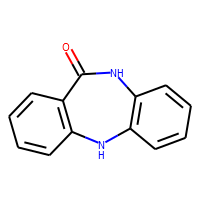
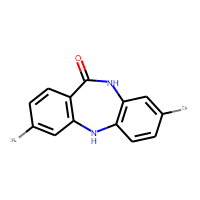
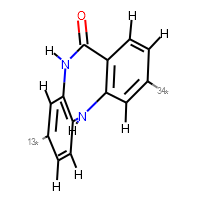
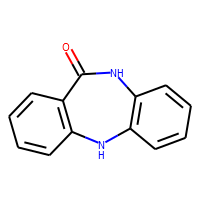
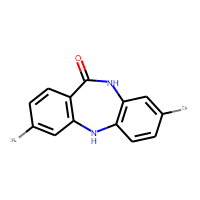
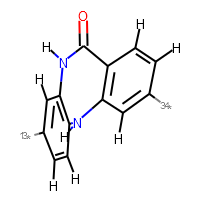

In [8]:
ap_fragments = fragment_library['AP']
print('Shape of AP fragment DataFrame: ', ap_fragments.shape)
ap_fragment_subset=ap_fragments[ap_fragments.smiles=='O=C1Nc2ccccc2Nc2ccccc21']
print('Shape of AP fragment subset: ', ap_fragment_subset.shape)
ap_fragment_subset.head()

## Check these code parts from 3_2
* fragments_reduced = fragment_library_concat_reduced.groupby('subpocket', sort=False).get_group(subpocket)
* smiles_match = fragments.smiles.isin(fragments_reduced.smiles)
* atom_environments_match = fragments.atom_environments.isin(fragments_reduced.atom_environments)
* atom_subpockets_match = fragments.atom_subpockets.isin(fragments_reduced.atom_subpockets)
* fragments['in_reduced_library'] = smiles_match & atom_environments_match & atom_subpockets_match

### Check AP fragment smiles_dummy, environments and atom subpockets

In [9]:
smiles_match=ap_fragments.smiles.isin(ap_fragment_reduced_subset.smiles)
smiles_match[smiles_match].index

Int64Index([723, 725, 740, 741, 742, 743], dtype='int64')

In [10]:
atom_environments_match = ap_fragments.atom_environments.isin(ap_fragment_reduced_subset.atom_environments)
atom_environments_match[atom_environments_match].index

Int64Index([723, 724, 725, 1717], dtype='int64')

In [11]:
atom_subpockets_match = ap_fragments.atom_subpockets.isin(ap_fragment_reduced_subset.atom_subpockets)
atom_subpockets_match[atom_subpockets_match].index

Int64Index([450, 723, 725, 1691, 1708, 1717, 2109, 2167, 2384], dtype='int64')

In [12]:
test=smiles_match & atom_environments_match & atom_subpockets_match
test[test].index

Int64Index([723, 725], dtype='int64')

In [13]:
ap_fragments.loc[723]

ROMol                <img data-content="rdkit/molecule" src="data:i...
ROMol_dummy          <img data-content="rdkit/molecule" src="data:i...
ROMol_original       <img data-content="rdkit/molecule" src="data:i...
kinase                                                            CHK1
family                                                           CAMKL
group                                                             CAMK
complex_pdb                                                       4fsy
ligand_pdb                                                         HK7
alt                                                                  B
chain                                                                A
atom_subpockets      AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...
atom_environments    16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 1...
smiles                                         O=C1Nc2ccccc2Nc2ccccc21
smiles_dummy                            [14*]c1ccc2c(c1)Nc1ccccc1NC2=O
subpoc

### Double check selected FP fragment

Shape of FP fragment DataFrame:  (192, 15)
Shape of FP fragment subset:  (1, 15)


,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles,smiles_dummy,subpocket
15,,,,AurA,Aur,Other,4ded,NHU,,A,FP FP FP FP FP FP FP FP FP FP FP FP FP FP FP AP,5 5 5 16 16 16 16 16 16 16 16 16 16 6 6 na,NC(=O)c1ccccc1,*c1ccccc1C(N)=O,FP

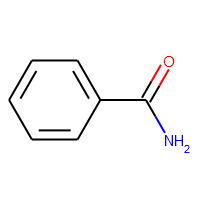
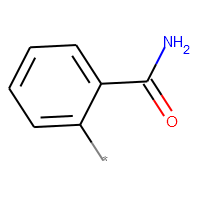
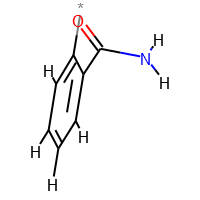

In [14]:
fp_fragments_reduced = fragment_library_reduced['FP']
print('Shape of FP fragment DataFrame: ', fp_fragments_reduced.shape)
fp_fragment_reduced_subset=fp_fragments_reduced[fp_fragments_reduced.smiles=='NC(=O)c1ccccc1']
print('Shape of FP fragment subset: ', fp_fragment_reduced_subset.shape)
fp_fragment_reduced_subset.head()

Shape of FP fragment DataFrame:  (1866, 15)
Shape of FP fragment subset:  (5, 15)


,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles,smiles_dummy,subpocket
105,,,,AurA,Aur,Other,4ded,NHU,,A,FP FP FP FP FP FP FP FP FP FP FP FP FP FP FP AP,5 5 5 16 16 16 16 16 16 16 16 16 16 6 6 na,NC(=O)c1ccccc1,[4*]c1ccccc1C(N)=O,FP
564,,,,CHK1,CAMKL,CAMK,4fsy,HK7,B,A,FP FP FP FP FP FP FP FP FP FP FP FP FP FP FP AP,6 6 5 5 5 16 16 16 16 16 16 16 16 16 16 na,NC(=O)c1ccccc1,[15*]c1ccccc1C(N)=O,FP
1174,,,,JNK1,MAPK,CMGC,2no3,859,,B,FP FP FP FP FP FP FP FP FP FP FP FP FP FP FP AP,16 16 16 16 16 16 16 16 16 16 6 5 5 5 6 na,NC(=O)c1ccccc1,[8*]c1ccccc1C(N)=O,FP
1658,,,,SYK,Syk,TK,5c26,50H,,A,FP FP FP FP FP FP FP FP FP FP FP FP FP FP FP AP,6 16 16 16 16 16 16 16 16 16 16 5 5 5 6 na,NC(=O)c1ccccc1,[28*]c1cccc(C(N)=O)c1,FP
1791,,,,TYK2-b,JakB,TK,6nze,L8Y,B,B,FP FP FP FP FP FP FP FP FP FP FP FP FP FP FP AP,16 16 16 16 16 16 16 6 16 16 16 5 5 5 6 na,NC(=O)c1ccccc1,[21*]c1ccccc1C(N)=O,FP

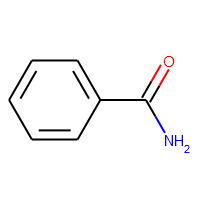
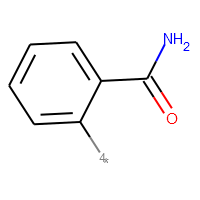
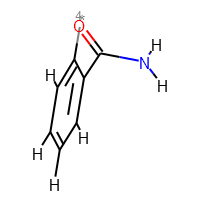
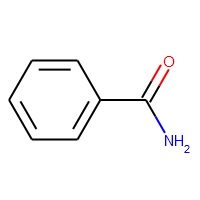
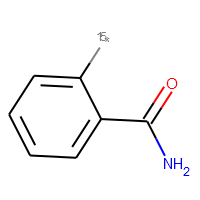
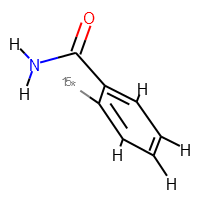
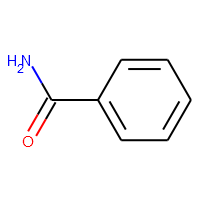
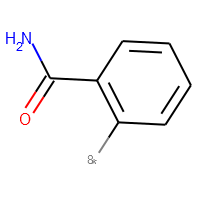
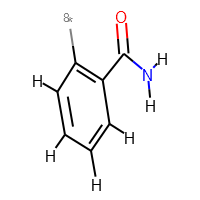
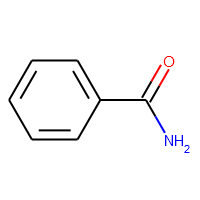
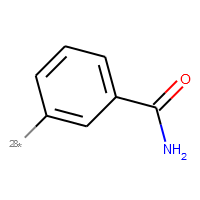
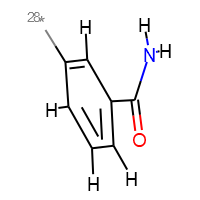
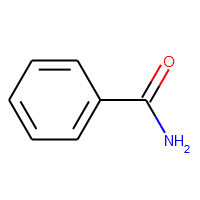
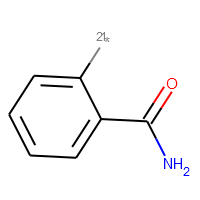
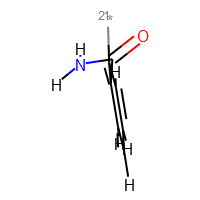

In [15]:
fp_fragments = fragment_library['FP']
print('Shape of FP fragment DataFrame: ', fp_fragments.shape)
fp_fragment_subset=fp_fragments[fp_fragments.smiles=='NC(=O)c1ccccc1']
print('Shape of FP fragment subset: ', fp_fragment_subset.shape)
fp_fragment_subset.head()

In [16]:
print(fp_fragment_subset.atom_subpockets)

105     FP FP FP FP FP FP FP FP FP FP FP FP FP FP FP AP
564     FP FP FP FP FP FP FP FP FP FP FP FP FP FP FP AP
1174    FP FP FP FP FP FP FP FP FP FP FP FP FP FP FP AP
1658    FP FP FP FP FP FP FP FP FP FP FP FP FP FP FP AP
1791    FP FP FP FP FP FP FP FP FP FP FP FP FP FP FP AP
Name: atom_subpockets, dtype: object


In [17]:
print(fp_fragment_subset.atom_environments)

105     5 5 5 16 16 16 16 16 16 16 16 16 16 6 6 na
564     6 6 5 5 5 16 16 16 16 16 16 16 16 16 16 na
1174    16 16 16 16 16 16 16 16 16 16 6 5 5 5 6 na
1658    6 16 16 16 16 16 16 16 16 16 16 5 5 5 6 na
1791    16 16 16 16 16 16 16 6 16 16 16 5 5 5 6 na
Name: atom_environments, dtype: object


### Check FP fragment smiles_dummy, environments and atom subpockets

In [18]:
smiles_match=fp_fragments.smiles.isin(fp_fragment_reduced_subset.smiles)
smiles_match[smiles_match].index

Int64Index([105, 564, 1174, 1658, 1791], dtype='int64')

In [19]:
atom_subpockets_match = fp_fragments.atom_subpockets.isin(fp_fragment_reduced_subset.atom_subpockets)
atom_subpockets_match[atom_subpockets_match].index

Int64Index([  64,   99,  105,  253,  268,  296,  354,  365,  395,  398,  399,
             408,  409,  411,  412,  413,  414,  445,  468,  503,  505,  507,
             509,  510,  518,  552,  564,  602,  615,  676,  736,  737,  738,
             750,  777,  785,  801,  806,  811,  817,  918,  927,  935,  939,
             945,  959, 1066, 1110, 1145, 1148, 1171, 1174, 1175, 1191, 1209,
            1237, 1356, 1418, 1482, 1603, 1627, 1639, 1650, 1652, 1658, 1661,
            1667, 1762, 1791],
           dtype='int64')

In [20]:
atom_environments_match = fp_fragments.atom_environments.isin(fp_fragment_reduced_subset.atom_environments)
atom_environments_match[atom_environments_match].index

Int64Index([105], dtype='int64')

In [21]:
test=smiles_match & atom_environments_match & atom_subpockets_match
test[test].index

Int64Index([105], dtype='int64')

### Fragment 564 not matched!

## So yes, using these functions the compound is theoretically not coverd.
### But it's just a different soritng of atoms and thus the atom environments! 
(I guess same can happen for subppockets as well)

In [22]:
print(fp_fragment_subset.atom_environments)

105     5 5 5 16 16 16 16 16 16 16 16 16 16 6 6 na
564     6 6 5 5 5 16 16 16 16 16 16 16 16 16 16 na
1174    16 16 16 16 16 16 16 16 16 16 6 5 5 5 6 na
1658    6 16 16 16 16 16 16 16 16 16 16 5 5 5 6 na
1791    16 16 16 16 16 16 16 6 16 16 16 5 5 5 6 na
Name: atom_environments, dtype: object


### Check one more example:  second row, first from left
* AP pocket yes: 51 | 2 | 4 | 1 | 5m4f | 7FC

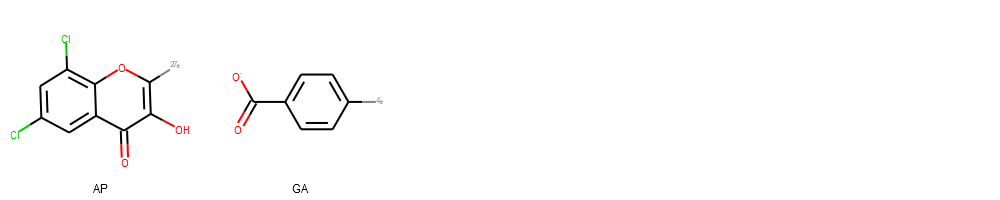

In [23]:
complex_pdb='5m4f'
ligand_pdb='7FC'

draw_fragmented_ligand_wdummy(fragment_library, complex_pdb, ligand_pdb, mols_per_row=5)

* GA pocker yes: 1 | 33 | 16 | 9 | 2e9o | A58

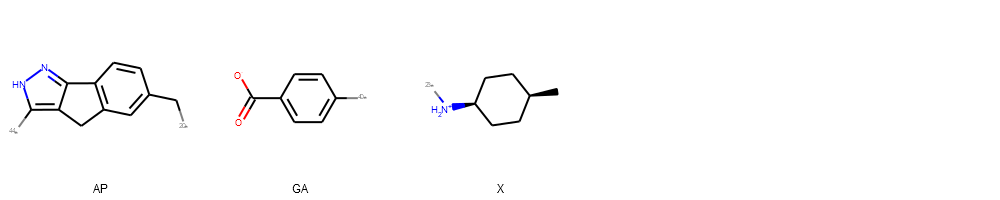

In [24]:
complex_pdb='2e9o'
ligand_pdb='A58'

draw_fragmented_ligand_wdummy(fragment_library, complex_pdb, ligand_pdb, mols_per_row=5)

## in 3_2 this return False for full_coverage as well:
original_ligands_coverage[original_ligands_coverage.complex_pdb=='5m4f']

Shape of GA fragment DataFrame:  (93, 15)
Shape of GA fragment subset:  (1, 15)


,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles,smiles_dummy,subpocket
0,,,,CHK1,CAMKL,CAMK,2e9o,A58,,A,GA GA GA GA GA GA GA GA GA GA GA GA GA AP,16 16 16 16 16 16 16 16 16 16 6 6 6 na,O=C([O-])c1ccccc1,*c1ccc(C(=O)[O-])cc1,GA

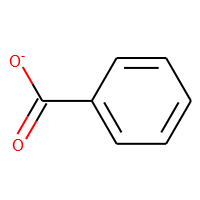
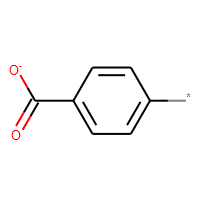
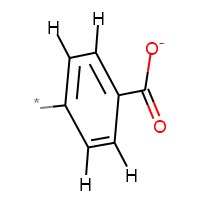

In [25]:
ga_fragments_reduced = fragment_library_reduced['GA']
print('Shape of GA fragment DataFrame: ', ga_fragments_reduced.shape)
ga_fragment_reduced_subset=ga_fragments_reduced[ga_fragments_reduced.smiles=='O=C([O-])c1ccccc1']
print('Shape of GA fragment subset: ', ga_fragment_reduced_subset.shape)
ga_fragment_reduced_subset.head()

Shape of GA fragment DataFrame:  (1024, 15)
Shape of GA fragment subset:  (16, 15)


,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles,smiles_dummy,subpocket
185,,,,CHK1,CAMKL,CAMK,2e9o,A58,,A,GA GA GA GA GA GA GA GA GA GA GA GA GA AP,16 16 16 16 16 16 16 16 16 16 6 6 6 na,O=C([O-])c1ccccc1,[40*]c1ccc(C(=O)[O-])cc1,GA
198,,,,CHK1,CAMKL,CAMK,4fsn,A58,A,A,GA GA GA GA GA GA GA GA GA GA GA GA GA AP,16 16 16 16 16 16 16 16 16 16 6 6 6 na,O=C([O-])c1ccccc1,[40*]c1ccc(C(=O)[O-])cc1,GA
217,,,,CHK1,CAMKL,CAMK,4qye,3DL,,A,GA GA GA GA GA GA GA GA GA GA GA GA GA AP,6 6 6 16 16 16 16 16 16 16 16 16 16 na,O=C([O-])c1ccccc1,[13*]c1ccc(C(=O)[O-])cc1,GA
218,,,,CHK1,CAMKL,CAMK,4qyf,3DV,,A,GA GA GA GA GA GA GA GA GA GA GA GA GA AP,6 6 6 16 16 16 16 16 16 16 16 16 16 na,O=C([O-])c1ccccc1,[13*]c1ccc(C(=O)[O-])cc1,GA
252,,,,CK2a1,CK2,CMGC,3axw,TID,,A,GA GA GA GA GA GA GA GA GA GA GA GA GA AP,16 16 16 16 16 16 16 16 16 16 6 6 6 na,O=C([O-])c1ccccc1,[13*]c1ccc(C(=O)[O-])cc1,GA
265,,,,CK2a1,CK2,CMGC,4ub7,3G5,,A,GA GA GA GA GA GA GA GA GA GA GA GA GA AP,16 16 16 16 16 6 6 6 16 16 16 16 16 na,O=C([O-])c1ccccc1,[24*]c1ccc(C(=O)[O-])cc1,GA
266,,,,CK2a1,CK2,CMGC,4uba,3G5,,A,GA GA GA GA GA GA GA GA GA GA GA GA GA AP,16 16 16 16 16 6 6 6 16 16 16 16 16 na,O=C([O-])c1ccccc1,[24*]c1ccc(C(=O)[O-])cc1,GA
267,,,,CK2a1,CK2,CMGC,5b0x,HCK,,A,GA GA GA GA GA GA GA GA GA GA GA GA GA AP,16 16 16 16 16 16 16 16 16 16 6 6 6 na,O=C([O-])c1ccccc1,[10*]c1ccc(C(=O)[O-])cc1,GA
278,,,,CK2a1,CK2,CMGC,5m4f,7FC,B,A,GA GA GA GA GA GA GA GA GA GA GA GA GA AP,16 16 6 6 16 16 16 16 16 16 6 16 16 na,O=C([O-])c1ccccc1,[4*]c1ccc(C(=O)[O-])cc1,GA
279,,,,CK2a1,CK2,CMGC,5m4i,7FC,,A,GA GA GA GA GA GA GA GA GA GA GA GA GA AP,16 16 6 6 16 16 16 16 16 16 6 16 16 na,O=C([O-])c1ccccc1,[4*]c1ccc(C(=O)[O-])cc1,GA

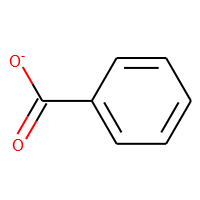
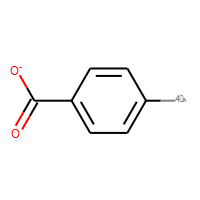
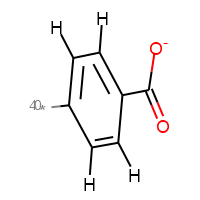
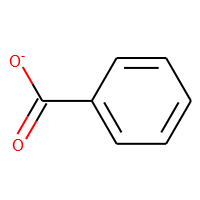
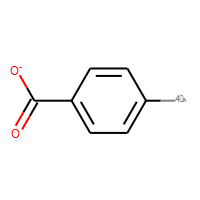
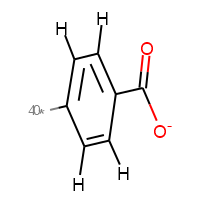
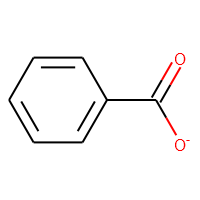
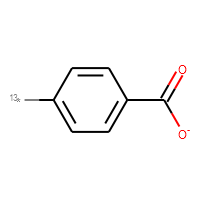
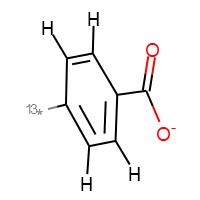
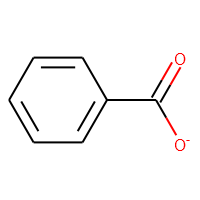
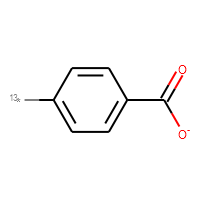
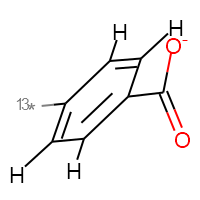
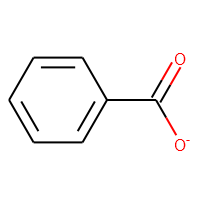
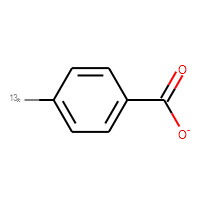
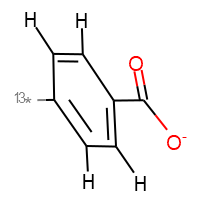
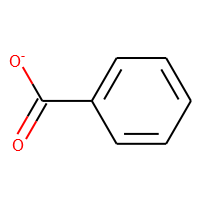
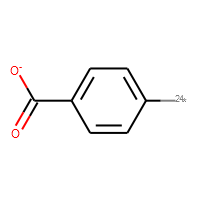
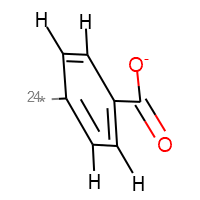
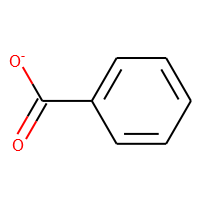
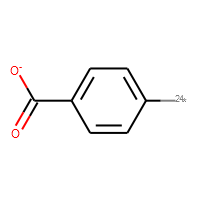
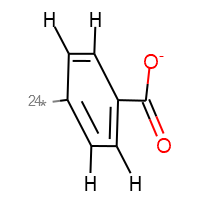
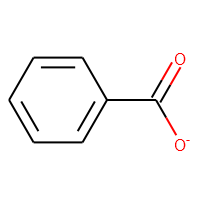
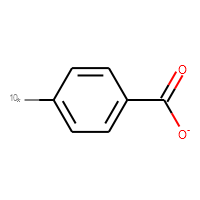
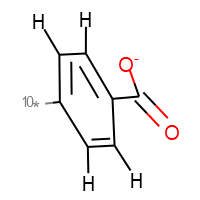
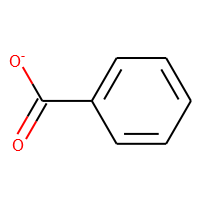
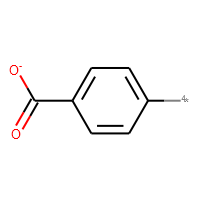
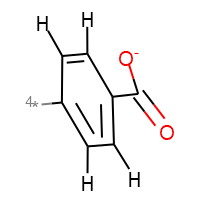
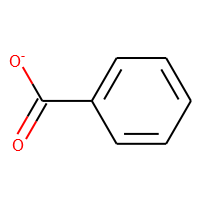
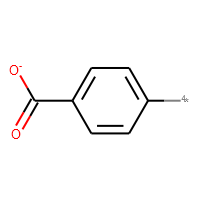
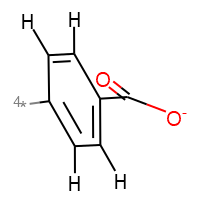
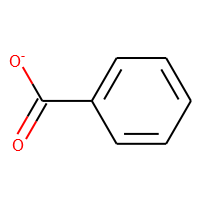
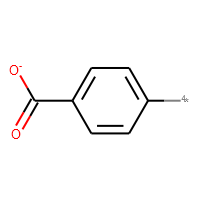
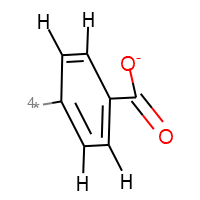
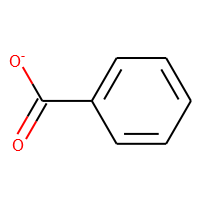
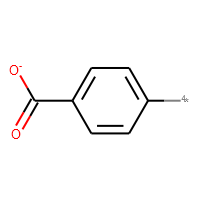
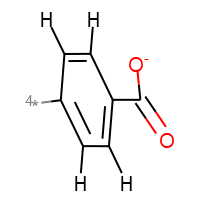
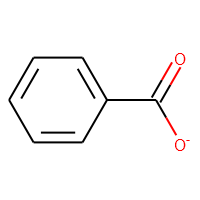
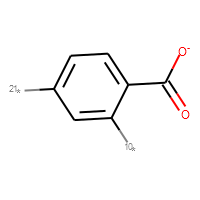
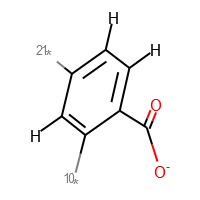
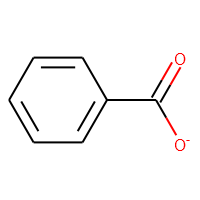
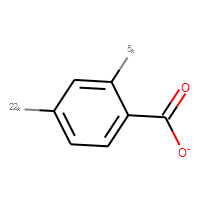
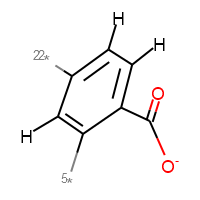
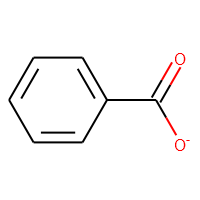
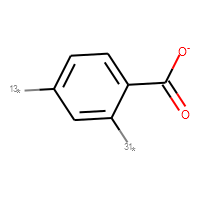
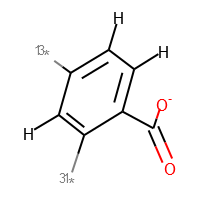
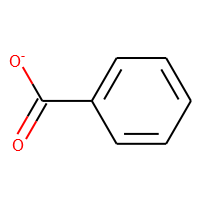
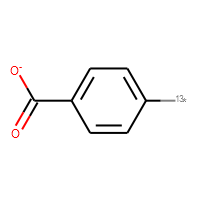
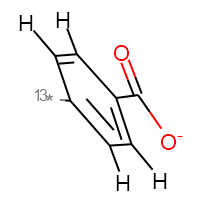

In [26]:
ga_fragments = fragment_library['GA']
print('Shape of GA fragment DataFrame: ', ga_fragments.shape)
ga_fragment_subset=ga_fragments[ga_fragments.smiles=='O=C([O-])c1ccccc1']
print('Shape of GA fragment subset: ', ga_fragment_subset.shape)
ga_fragment_subset.head(16)

In [27]:
smiles_match=ga_fragments.smiles.isin(ga_fragment_reduced_subset.smiles)
smiles_match[smiles_match].index

Int64Index([185, 198, 217, 218, 252, 265, 266, 267, 278, 279, 292, 293, 319,
            320, 328, 333],
           dtype='int64')

In [28]:
atom_environments_match = ga_fragments.atom_environments.isin(ga_fragment_reduced_subset.atom_environments)
atom_environments_match[atom_environments_match].index

Int64Index([185, 198, 252, 267], dtype='int64')

In [29]:
atom_subpockets_match = ga_fragments.atom_subpockets.isin(ga_fragment_reduced_subset.atom_subpockets)
atom_subpockets_match[atom_subpockets_match].index

Int64Index([ 113,  132,  133,  139,  140,  161,  185,  198,  217,  218,  252,
             260,  265,  266,  267,  278,  279,  292,  293,  330,  331,  332,
             333,  338,  347,  348,  349,  351,  352,  358,  377,  396,  398,
             403,  528,  568,  569,  577,  578,  579,  591,  615,  618,  621,
             624,  625,  627,  630,  631,  634,  635,  636,  638,  646,  723,
             734,  735,  758,  760,  794,  842,  843,  844,  874, 1018],
           dtype='int64')

In [30]:
test=smiles_match & atom_environments_match & atom_subpockets_match
test[test].index

Int64Index([185, 198, 252, 267], dtype='int64')

### Fragment 278 not matched